<a href="https://colab.research.google.com/github/shreyash-alt/MARS-RL-Assignment-2025/blob/main/EpsilonGreedyVSSoftmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Epsilon Greedy VS Softmax on FrozenLake**

Training with ε-greedy...
Episode 10000, Successes (last 10000): 8846
Episode 20000, Successes (last 10000): 9897
Episode 30000, Successes (last 10000): 9889
Episode 40000, Successes (last 10000): 9896
Episode 50000, Successes (last 10000): 9900
Episode 60000, Successes (last 10000): 9884
Episode 70000, Successes (last 10000): 9912
Episode 80000, Successes (last 10000): 9909
Episode 90000, Successes (last 10000): 9893
Episode 100000, Successes (last 10000): 9908
Training with Softmax (τ=1)...
Episode 10000, Successes (last 10000): 678
Episode 20000, Successes (last 10000): 727
Episode 30000, Successes (last 10000): 764
Episode 40000, Successes (last 10000): 717
Episode 50000, Successes (last 10000): 722
Episode 60000, Successes (last 10000): 728
Episode 70000, Successes (last 10000): 723
Episode 80000, Successes (last 10000): 715
Episode 90000, Successes (last 10000): 665
Episode 100000, Successes (last 10000): 740
Training with Softmax (τ=2)...
Episode 10000, Successes (last 10000): 3

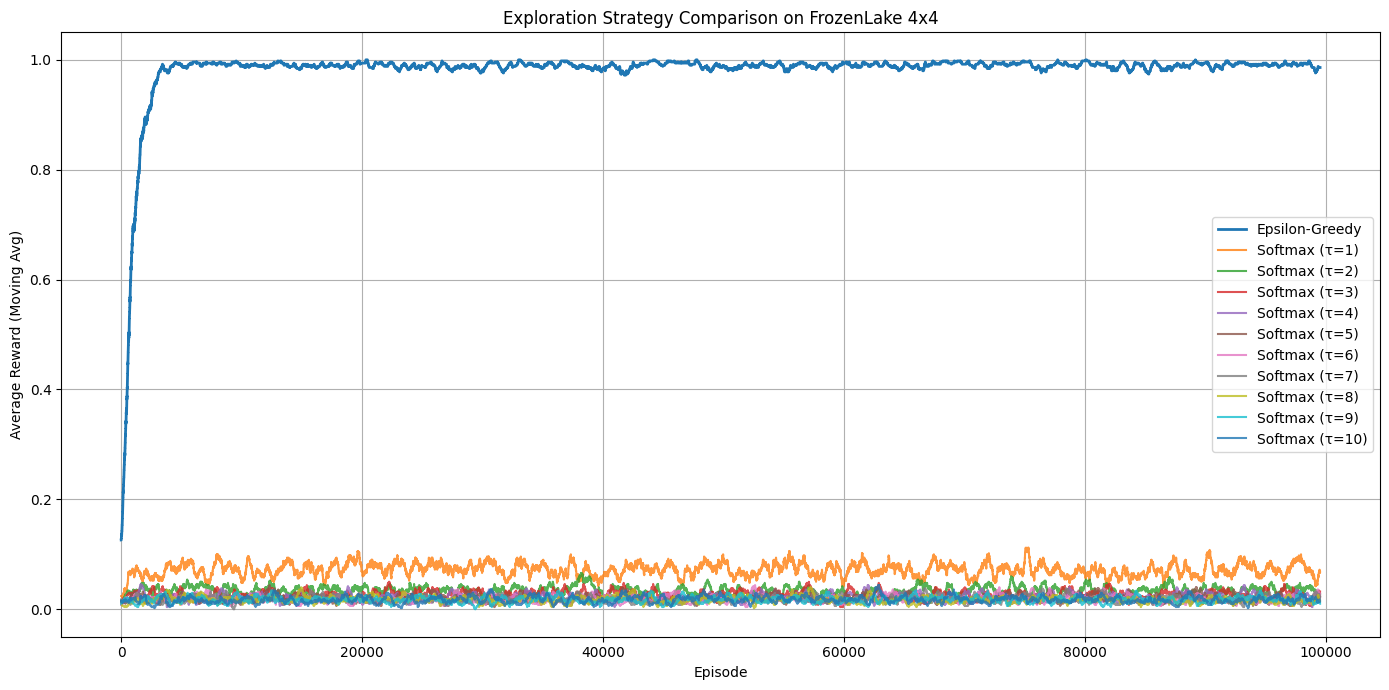

In [2]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

def epsilon_greedy(q_values, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(q_values))
    return np.argmax(q_values)

def softmax(q_values, tau):
    q_values = np.array(q_values)
    q_values -= np.max(q_values)  # numerical stability
    exp_q = np.exp(q_values / tau)
    probs = exp_q / np.sum(exp_q)
    return np.random.choice(len(q_values), p=probs)

def train_q_learning(env, action_selector, episodes=20000, alpha=0.1, gamma=0.99, **selector_kwargs):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    success_count = 0

    epsilon = selector_kwargs.get("epsilon", 1.0)
    tau = selector_kwargs.get("tau", 1.0)

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            q_vals = q_table[state]

            if action_selector == epsilon_greedy:
                action = action_selector(q_vals, epsilon)
            else:
                action = action_selector(q_vals, tau)

            next_state, reward, done, truncated, _ = env.step(action)
            shaped_reward = reward if reward == 1 else -0.01

            best_next = np.max(q_table[next_state])
            q_table[state, action] += alpha * (shaped_reward + gamma * best_next - q_table[state, action])

            state = next_state
            total_reward += reward

        if reward == 1:
            success_count += 1
        rewards.append(total_reward)

        if action_selector == epsilon_greedy:
            epsilon = max(0.01, epsilon * 0.999)

        if (episode + 1) % 10000 == 0:
            print(f"Episode {episode + 1}, Successes (last 10000): {success_count}")
            success_count = 0

    return rewards

def moving_avg(data, window=500):
    return np.convolve(data, np.ones(window)/window, mode='valid')


env = gym.make("FrozenLake-v1",is_slippery=False)

# ε-greedy training
print("Training with ε-greedy...")
rewards_eps = train_q_learning(env, epsilon_greedy, episodes=100000, epsilon=1.0)

# Softmax with τ = 1 to 10
softmax_results = {}
for tau in range(1, 11):
    print(f"Training with Softmax (τ={tau})...")
    rewards = train_q_learning(env, softmax, episodes=100000, tau=tau)
    softmax_results[tau] = rewards

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(moving_avg(rewards_eps), label="Epsilon-Greedy", linewidth=2)

for tau, rewards in softmax_results.items():
    plt.plot(moving_avg(rewards), label=f"Softmax (τ={tau})", alpha=0.8)

plt.xlabel("Episode")
plt.ylabel("Average Reward (Moving Avg)")
plt.title("Exploration Strategy Comparison on FrozenLake 4x4")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Epsilon Greedy VS Softmax on CartPole**

Training with ε-greedy...
Episode:1000 Reward:512.0
Episode:2000 Reward:1408.0
Episode:3000 Reward:3200.0
Episode:4000 Reward:3200.0
Episode:5000 Reward:3200.0
Episode:6000 Reward:3200.0
Episode:7000 Reward:3200.0
Episode:8000 Reward:3200.0
Episode:9000 Reward:3200.0
Episode:10000 Reward:528.0
Training with Softmax (τ=1)...
Episode:1000 Reward:176.0
Episode:2000 Reward:784.0
Episode:3000 Reward:320.0
Episode:4000 Reward:240.0
Episode:5000 Reward:288.0
Episode:6000 Reward:208.0
Episode:7000 Reward:176.0
Episode:8000 Reward:176.0
Episode:9000 Reward:352.0
Episode:10000 Reward:176.0
Training with Softmax (τ=2)...
Episode:1000 Reward:432.0
Episode:2000 Reward:304.0
Episode:3000 Reward:176.0
Episode:4000 Reward:240.0
Episode:5000 Reward:304.0
Episode:6000 Reward:1584.0
Episode:7000 Reward:1056.0
Episode:8000 Reward:240.0
Episode:9000 Reward:224.0
Episode:10000 Reward:240.0
Training with Softmax (τ=3)...
Episode:1000 Reward:336.0
Episode:2000 Reward:288.0
Episode:3000 Reward:352.0
Episode:40

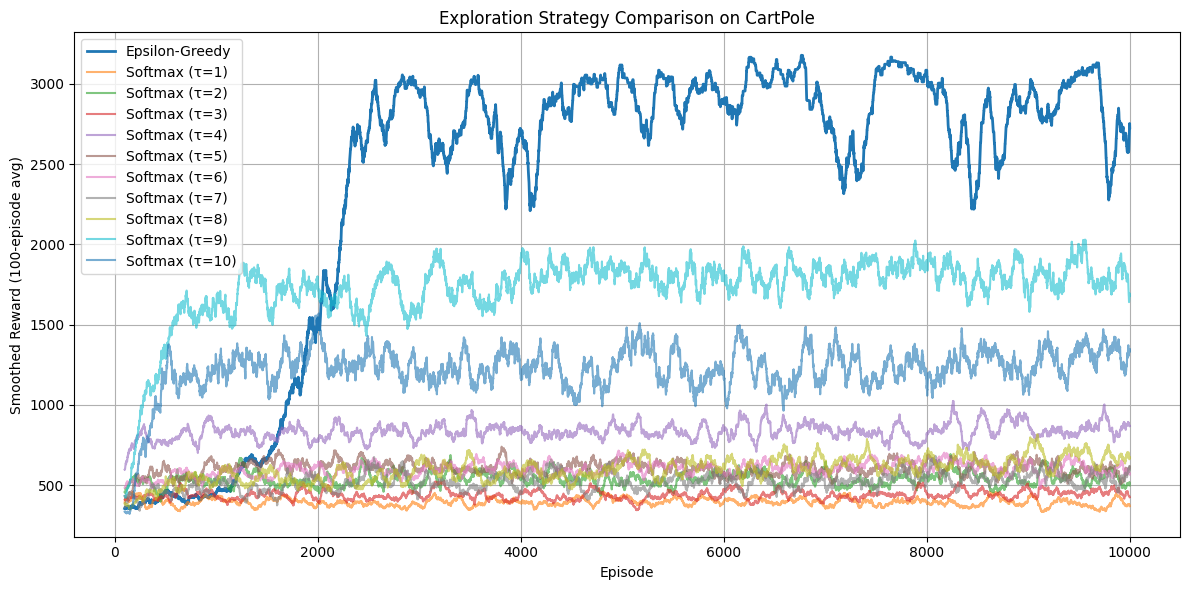

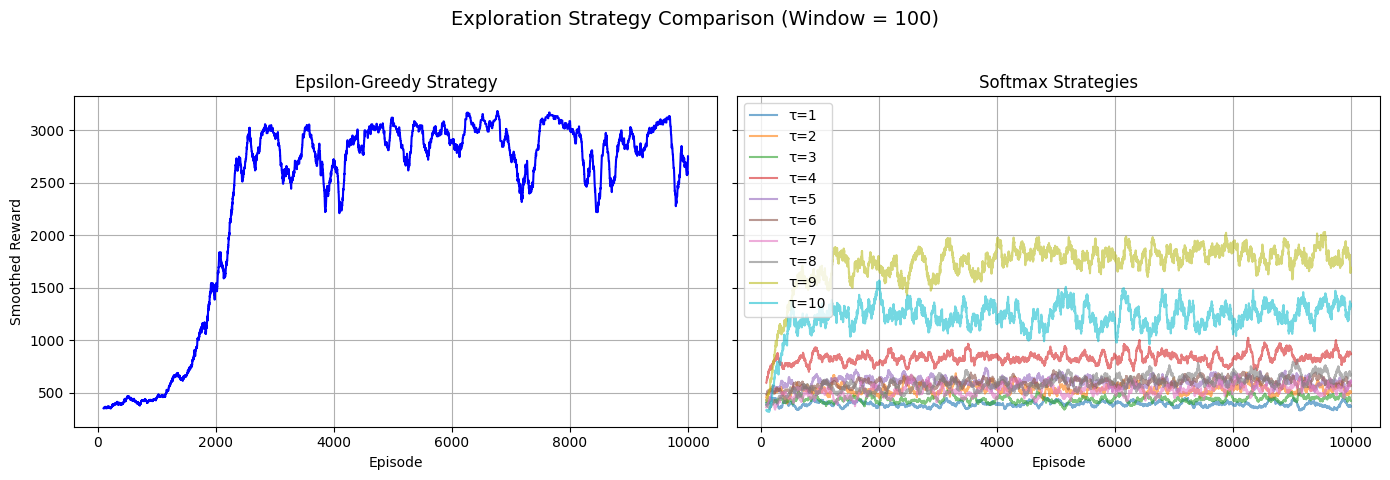

In [1]:
import gymnasium as gym
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

env = gym.make("CartPole-v1")
state, _ = env.reset()

# Discretization
NUM_BINS = [24, 24, 24, 24]  # More bins for better accuracy
obs_space_high = env.observation_space.high
obs_space_low = env.observation_space.low
obs_space_low[1] = -10
obs_space_high[1] = 10
obs_space_low[3] = -np.radians(80)
obs_space_high[3] = np.radians(80)
bin_width = (obs_space_high - obs_space_low) / NUM_BINS

def get_discrete_state(state):
    ratios = (state - obs_space_low) / bin_width
    discrete_state = np.clip(ratios.astype(int), 0, np.array(NUM_BINS) - 1)
    return tuple(discrete_state)

EPISODES = 10000
LEARNING_RATE = 0.1
DISCOUNT = 0.95
START_EPSILON_DECAY = 1
END_EPSILON_DECAY = EPISODES // 2
MAX_STEPS = 200

def epsilon_greedy(q_values, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(q_values))
    return np.argmax(q_values)

def softmax(q_values, tau):
    q_values = np.array(q_values)
    q_values -= np.max(q_values)  # numerical stability
    exp_q = np.exp(q_values / tau)
    probs = exp_q / np.sum(exp_q)
    return np.random.choice(len(q_values), p=probs)

def train(action_selector, tau=None):
    q_table = np.random.uniform(low=-1, high=1, size=(NUM_BINS + [env.action_space.n]))
    epsilon = 1.0
    rewards = []

    for episode in range(EPISODES):
        state, _ = env.reset()
        discrete_state = get_discrete_state(state)
        done = False
        episode_reward = 0

        for step in range(MAX_STEPS):
            if action_selector == 'epsilon':
                action = epsilon_greedy(q_table[discrete_state], epsilon)
            else:
                action = softmax(q_table[discrete_state], tau)

            new_state, reward, terminated, truncated, _ = env.step(action)
            new_discrete_state = get_discrete_state(new_state)
            v=new_discrete_state[1]
            p=new_state[2]
            cp=new_state[0]
            if(v<=30 and v>=25):
                reward+=15
            if(p<=np.radians(20) and p>=-np.radians(20)):
                reward+=15
            done = terminated or truncated
            episode_reward += reward

            if not done:
                max_future_q = np.max(q_table[new_discrete_state])
                current_q = q_table[discrete_state + (action,)]
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
                q_table[discrete_state + (action,)] = new_q
            else:
                q_table[discrete_state + (action,)] = reward

            discrete_state = new_discrete_state

            if done:
                break

        rewards.append(episode_reward)
        if action_selector == 'epsilon':
            epsilon = max(0.01, epsilon * 0.999)

        if (episode + 1) % 1000 == 0:
            print(f"Episode:{episode + 1} Reward:{episode_reward}")

    return rewards

# Train epsilon-greedy
print("Training with ε-greedy...")
epsilon_rewards = train('epsilon')

# Train softmax with various τ values
tau_values = list(range(1, 11))
softmax_results = {}

for tau in tau_values:
    print(f"Training with Softmax (τ={tau})...")
    rewards = train('softmax', tau=tau)
    softmax_results[tau] = rewards

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(pd.Series(epsilon_rewards).rolling(100).mean(), label="Epsilon-Greedy", linewidth=2)
for tau in tau_values:
    plt.plot(pd.Series(softmax_results[tau]).rolling(100).mean(), label=f"Softmax (τ={tau})", alpha=0.6)
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward (100-episode avg)")
plt.title("Exploration Strategy Comparison on CartPole")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Side-by-side comparison
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
axs[0].plot(pd.Series(epsilon_rewards).rolling(100).mean(), color='blue')
axs[0].set_title("Epsilon-Greedy Strategy")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Smoothed Reward")
axs[0].grid(True)

for tau in tau_values:
    axs[1].plot(pd.Series(softmax_results[tau]).rolling(100).mean(), label=f"τ={tau}", alpha=0.6)
axs[1].set_title("Softmax Strategies")
axs[1].set_xlabel("Episode")
axs[1].grid(True)
axs[1].legend()

fig.suptitle("Exploration Strategy Comparison (Window = 100)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
